# Предсказание модели

In [20]:
import os
import sys
from copy import deepcopy
from collections import defaultdict
from itertools import combinations
sys.path.insert(0, os.path.join('..'))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial import calculate_metrics

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C
from radial.batchflow.models.tf import ResNet, ResNeXt18

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch
from radial.core.pipelines import create_preprocess_pipeline, create_train_pipeline

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [4, 8, 16],
    'initial_block/filters': 4,
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [6]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)

In [7]:
prep_pipeline = (Pipeline().load(fmt='npz')
                    .drop_negative(src=['time', 'derivative'])
                    .normalize(src=['time', 'derivative', 'target'],
                               dst=['time', 'derivative', 'target'],
                               src_range=[None, None, 'derivative_q'],
                               dst_range=[None, 'derivative_q', None])
                    .get_samples(N_SAMPLES, n_samples=1, sampler=np.random.random, src=['time', 'derivative'])
                    .make_points(src=['time', 'derivative'], dst=['points'])
                    .make_target(src='target')
                )

train_pipeline = create_train_pipeline(ResNet, model_config, prep_pipeline) << ds_train

In [8]:
train_pipeline.run(50, n_epochs=300, drop_last=True, shuffle=True, bar=True)

  0%|          | 0/1800 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|██████████| 1800/1800 [13:22<00:00,  2.28it/s]


In [9]:
results = defaultdict(lambda: defaultdict(list))
test_pipeline = prep_pipeline + (Pipeline()
                        .init_variable('predictions', init_on_each_run=list)
                        .init_variable('targets', init_on_each_run=list)
                        .import_model('model', train_pipeline)
                        .init_variable('ind', init_on_each_run=list)
                        .update_variable('ind', B('indices'), mode='e')
                        .predict_model('model', fetches='predictions',
                                                feed_dict={'points': B('points'),
                                                           'targets': B('target')},
                                        save_to=B('predictions'), mode='w')
                        .denormalize_component(src=['predictions', 'target'], 
                                               dst=['denorm_predictions', 'denorm_target'],
                                               src_range=['derivative_q', 'derivative_q'])
                        .update_variable('predictions', B('denorm_predictions'), mode='e')
                        .update_variable('targets', B('denorm_target'), mode='e') << ds_test
)

In [10]:
test_pipeline.run(1, n_epochs=100, drop_last=True, bar=True)

100%|█████████▉| 8999/9000 [02:21<00:00, 63.14it/s]


In [11]:
for i in range(len(test_pipeline.get_variable('ind'))):
    results[test_pipeline.get_variable('ind')[i]]['pred'].append(np.ravel(test_pipeline.get_variable('predictions')[i])[0])
    results[test_pipeline.get_variable('ind')[i]]['true'] = test_pipeline.get_variable('targets')[i]

In [12]:
true = []
pred = []
for key in results.keys():
    results[key]['pred'] = np.mean(results[key]['pred'])
    true.append(results[key]['true'][0])
    pred.append(results[key]['pred'])

In [13]:
log_true = np.log10(true)

In [14]:
log_pred = np.log10(pred)

MAE: 0.1683
MAPE: 0.124
Percentage of error less than 30%: 90.0%


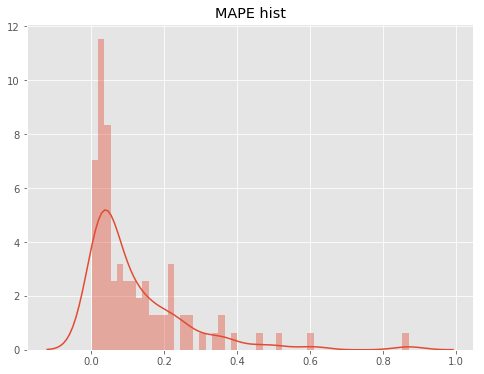

In [21]:
calculate_metrics(log_true, log_pred, 50)